# NPPC historical phenotypic wheat data analysis

## Load packages and data

In [1]:
library(readxl)
library(tidyverse)
library(multtest)
library(asreml)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
  

Online License checked out Wed Nov 15 19:13:29 2023


In [2]:
preprocess <- function(data_file){
                experiments <- read_xlsx(data_file, sheet = "Experiment") |> rename_with(~tolower(gsub(" ", "_", .x)))
                observations <- read_xlsx(data_file, sheet = "Observed scores") |> rename_with(~tolower(gsub(" ", "_", .x)))
                return(observations |> left_join(experiments, by = "experiment_id") |>
                        unite("campaign", c(year_start,year_end), sep="-") |>
                        select(accenumb, campaign, days_to_heading:last(colnames(observations))) |>
                        drop_na(accenumb, campaign) |> distinct() |> arrange(campaign, accenumb))}

In [3]:
data_total_winter <- preprocess("Historic_Wheat_W_NPPC.xlsx")
write_csv(data_total_winter, "NPPC_winter_wheat.csv")
genotypes_w <- distinct(data_total_winter["accenumb"]) |> rename("genotype" = "accenumb")
cat("Winter Wheat:\n", nrow(data_total_winter), "observations\n", nrow(genotypes_w), "genotypes\n", nrow(distinct(data_total_winter["campaign"])), "campaigns\n\n")
summary(data_total_winter[-c(1,2)])

Winter Wheat:
 6180 observations
 4893 genotypes
 40 campaigns



 days_to_heading thousand_kernel_weight  plant_height   
 Min.   : 63.0   Min.   :10.90          Min.   :  9.50  
 1st Qu.:216.0   1st Qu.:38.10          1st Qu.: 81.00  
 Median :222.0   Median :42.15          Median : 92.00  
 Mean   :221.9   Mean   :42.35          Mean   : 94.63  
 3rd Qu.:229.0   3rd Qu.:46.50          3rd Qu.:106.67  
 Max.   :299.0   Max.   :87.95          Max.   :198.33  
 NA's   :608     NA's   :1793           NA's   :179     

In [4]:
data_total_spring <- preprocess("Historic_Wheat_S_NPPC.xlsx")
write_csv(data_total_spring, "NPPC_spring_wheat.csv")
genotypes_s <- distinct(data_total_spring["accenumb"]) |> rename("genotype" = "accenumb")
cat("Spring Wheat:\n", nrow(data_total_spring), "observations\n", nrow(genotypes_s), "genotypes\n", nrow(distinct(data_total_spring["campaign"])), "campaigns\n\n")
summary(data_total_spring[-c(1,2)])

Spring Wheat:
 944 observations
 891 genotypes
 31 campaigns



 days_to_heading thousand_kernel_weight  plant_height   
 Min.   : 53.0   Min.   :21.10          Min.   : 35.00  
 1st Qu.: 77.0   1st Qu.:33.50          1st Qu.: 71.00  
 Median :216.0   Median :37.80          Median : 88.36  
 Mean   :162.1   Mean   :37.98          Mean   : 89.62  
 3rd Qu.:238.0   3rd Qu.:41.15          3rd Qu.:107.33  
 Max.   :266.0   Max.   :60.10          Max.   :165.34  
 NA's   :47      NA's   :380            NA's   :4       

## Subset data, remove missing values and singletons, make factors

In [5]:
make_data_sub <- function(full_df, trait){
                    data_sub <- full_df |> select("accenumb", "campaign", all_of(trait)) |> drop_na() |> distinct() |>
                    group_by(accenumb) |> filter(n()>1) |> group_by(campaign) |> filter(n()>1) |> 
                    mutate_at(vars(accenumb, campaign), factor)
                    cat(nrow(data_sub), trait, "rows kept\n") 
                    return(as.data.frame(data_sub))}

In [6]:
cat("Winter:\n")
data_sub_WW_HT <- data_total_winter |> make_data_sub("days_to_heading")
data_sub_WW_PH <- data_total_winter |> make_data_sub("plant_height")
data_sub_WW_TKW <- data_total_winter |> make_data_sub("thousand_kernel_weight")

Winter:
1045 days_to_heading rows kept
1887 plant_height rows kept
1682 thousand_kernel_weight rows kept


In [7]:
cat("Spring:\n")
data_sub_SW_HT <- data_total_spring |> make_data_sub("days_to_heading")
data_sub_SW_PH <- data_total_spring |> make_data_sub("plant_height")
data_sub_SW_TKW <- data_total_spring |> make_data_sub("thousand_kernel_weight")

Spring:
14 days_to_heading rows kept
77 plant_height rows kept
42 thousand_kernel_weight rows kept


## Visualise trait values 

In [8]:
options(repr.plot.width=12, repr.plot.height=7)
visualise_trait <- function(data_sub, geom){
                    trait <- colnames(data_sub)[3]
                    trait_title <- trait |> str_replace_all("_", " ") |> str_to_title()
                    plot(ggplot(data_sub, aes(campaign,.data[[trait]])) + geom_jitter()
                         + theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=0.5))
                         + labs(title = trait_title, subtitle = "Trait values per campaign",))
                    plot(ggplot(data_sub, aes(.data[[trait]])) + geom
                         + labs(title = trait_title, subtitle = "Distribution of trait values",))}

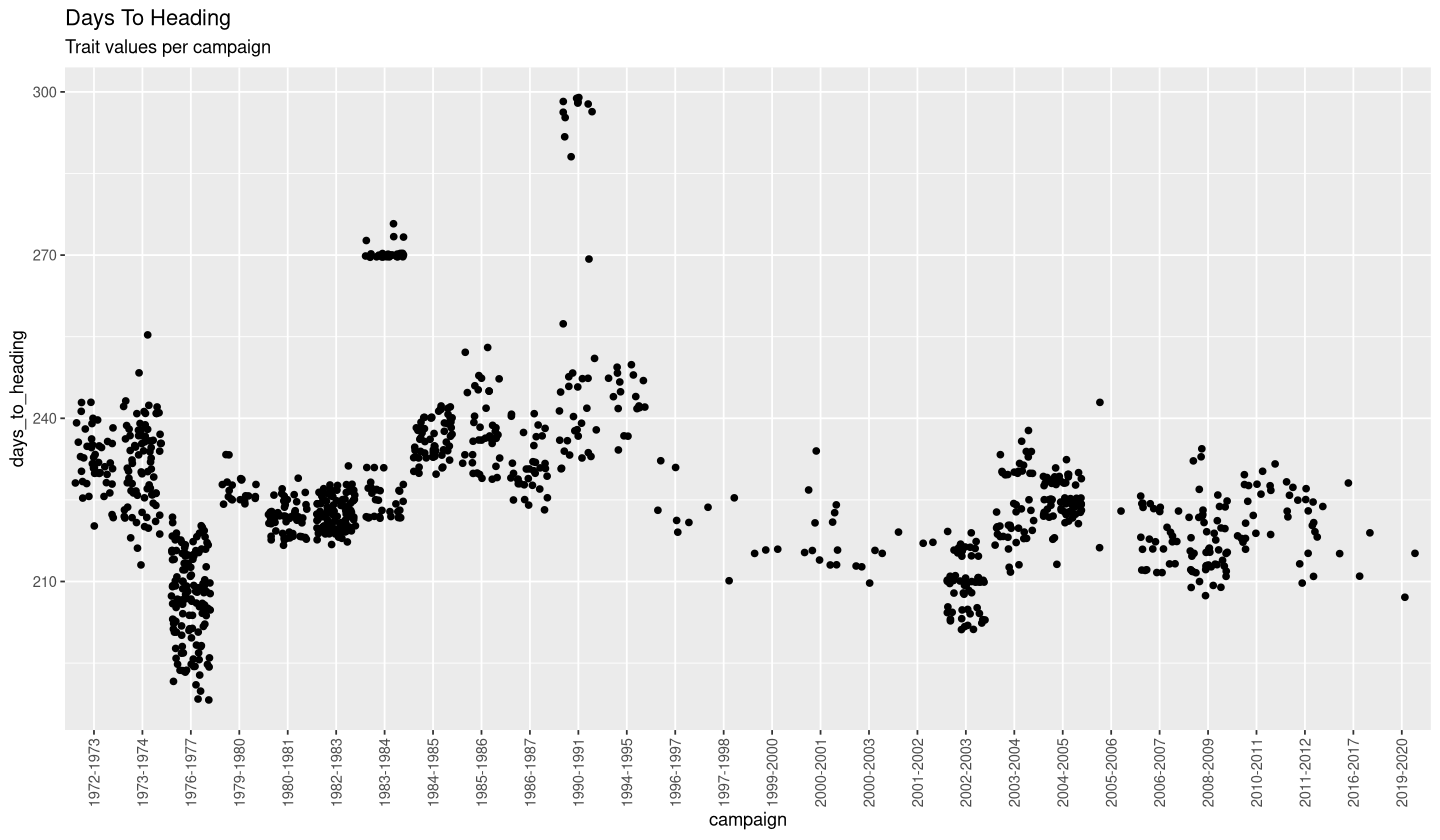

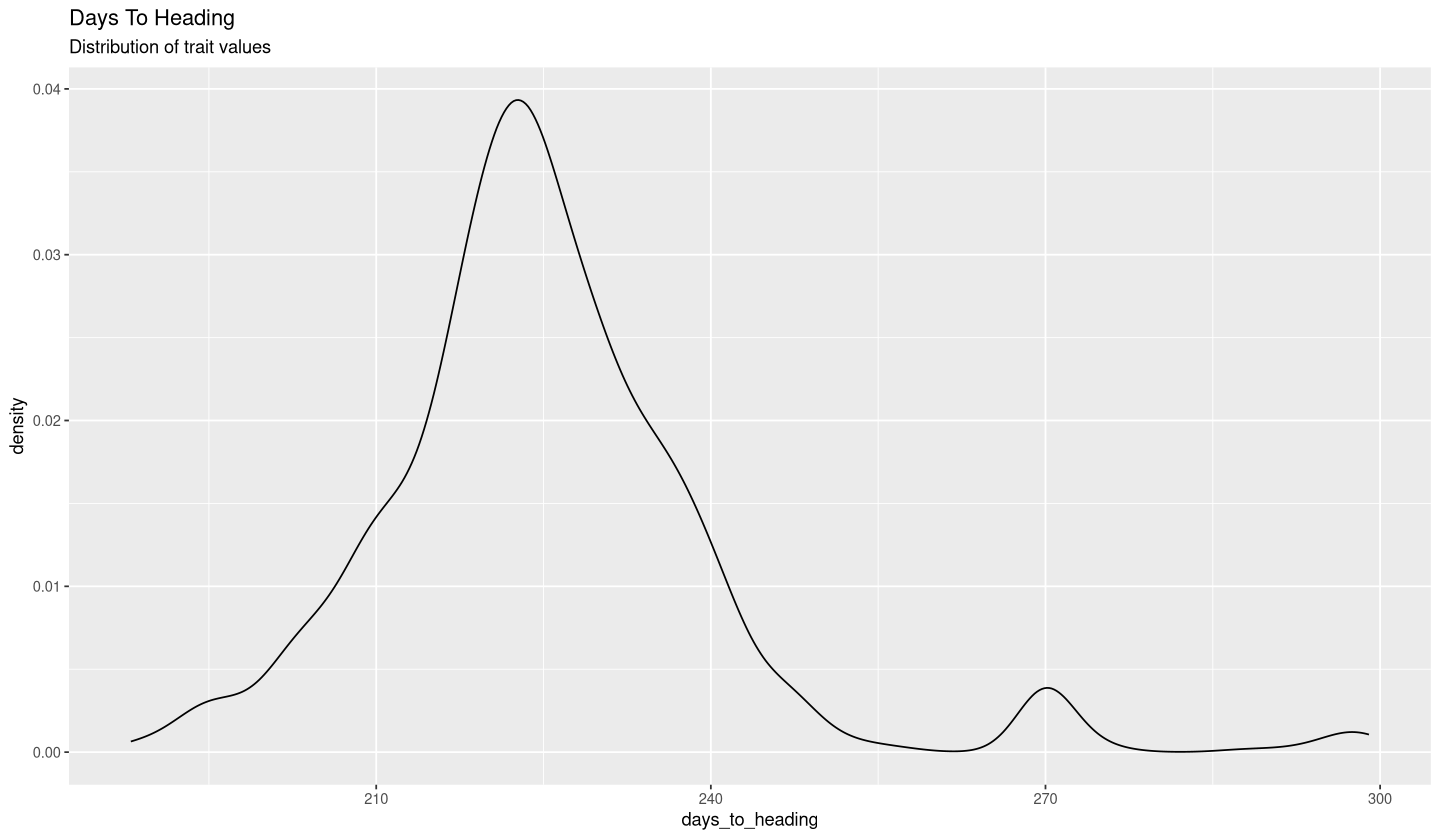

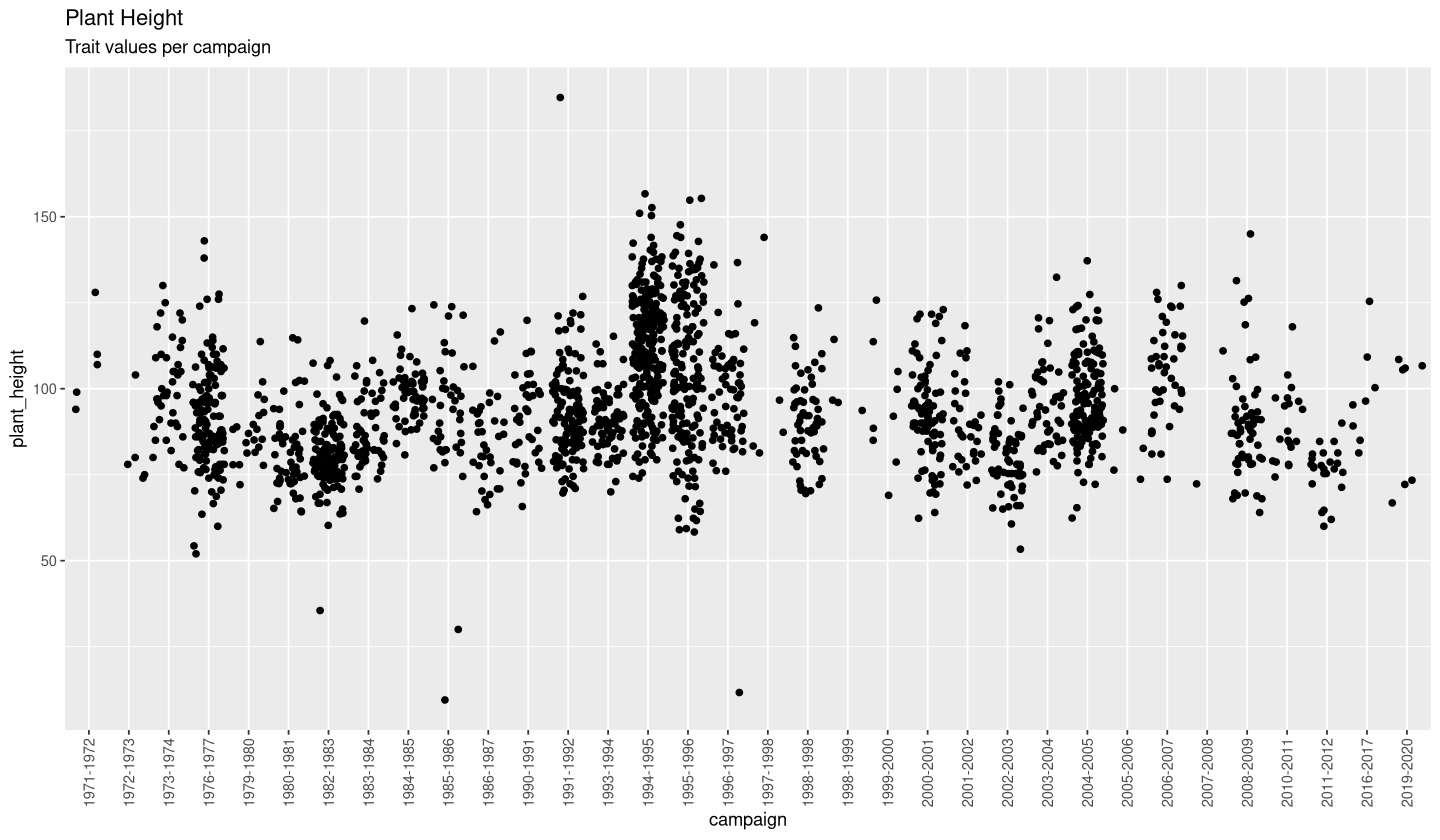

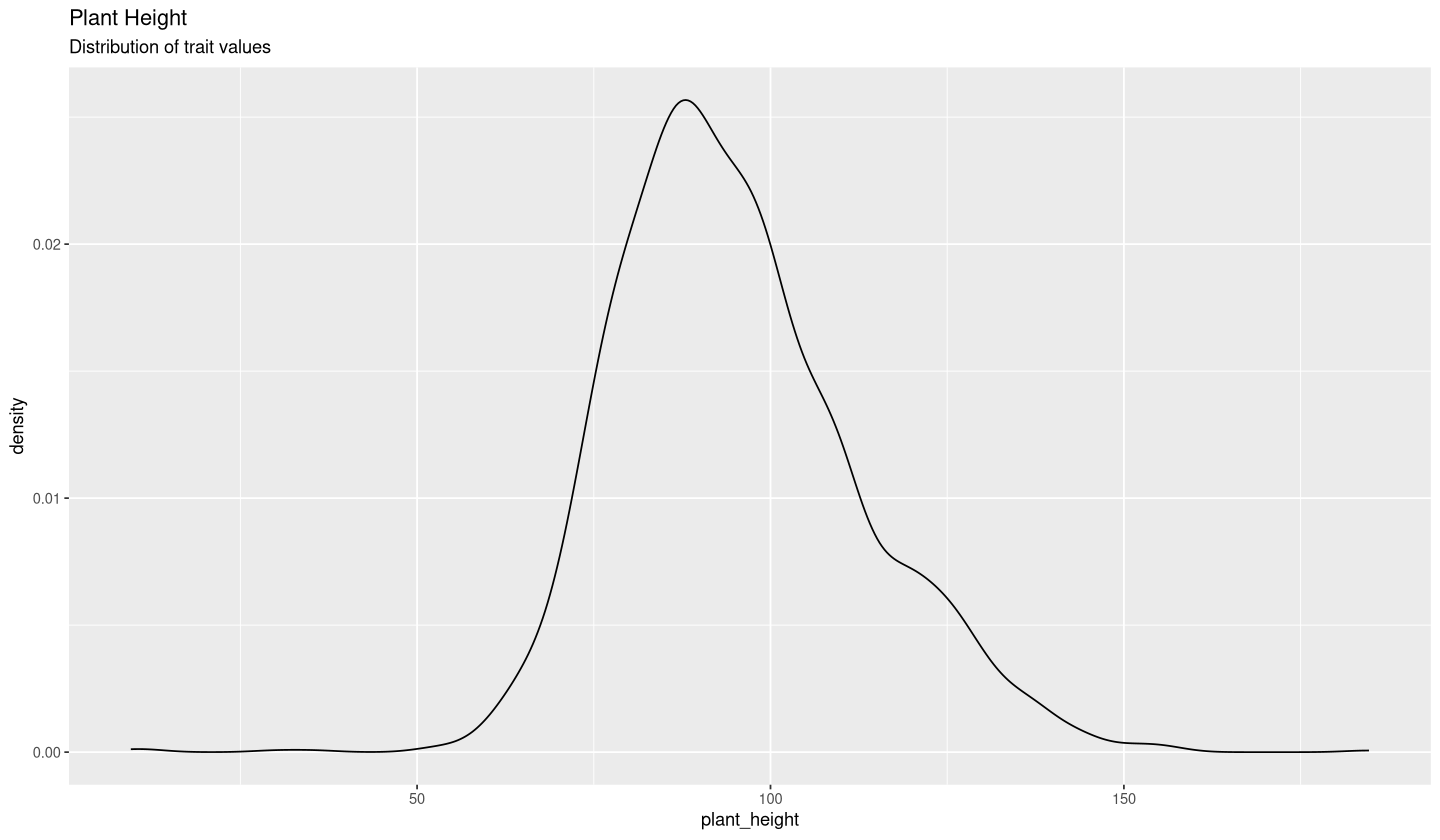

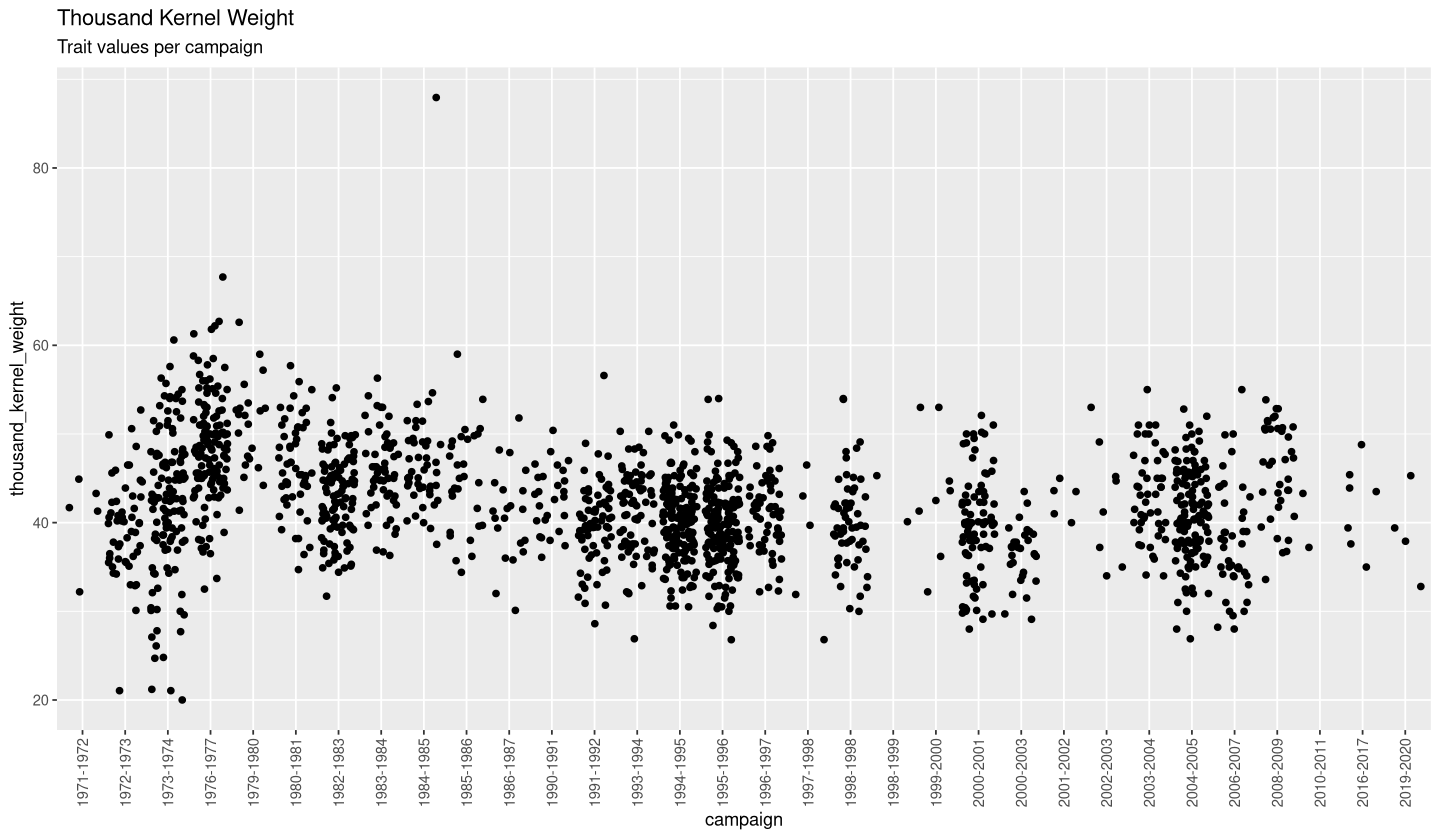

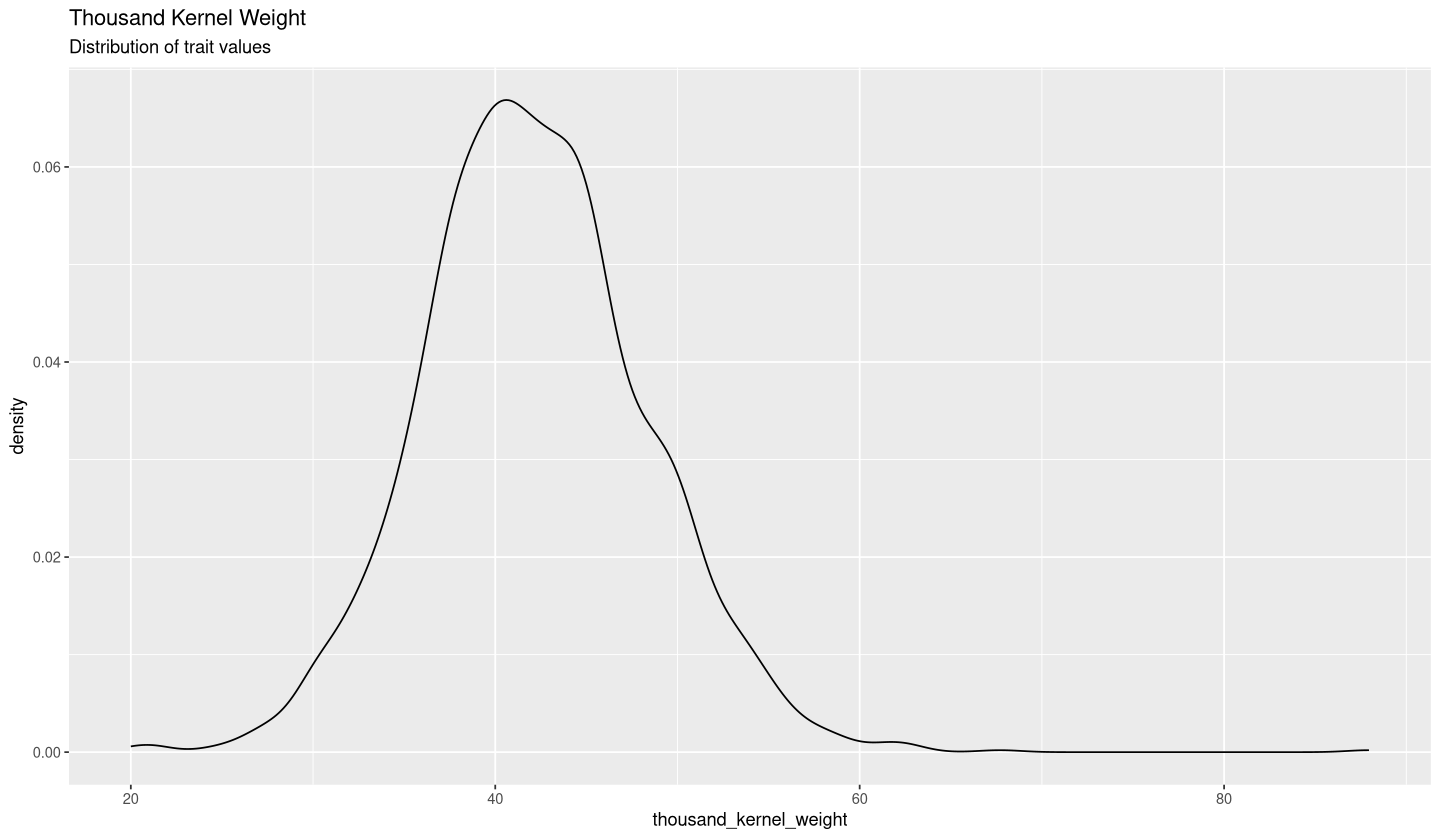

In [9]:
data_sub_WW_HT |> visualise_trait(geom_density())
data_sub_WW_PH |> visualise_trait(geom_density())
data_sub_WW_TKW |> visualise_trait(geom_density())

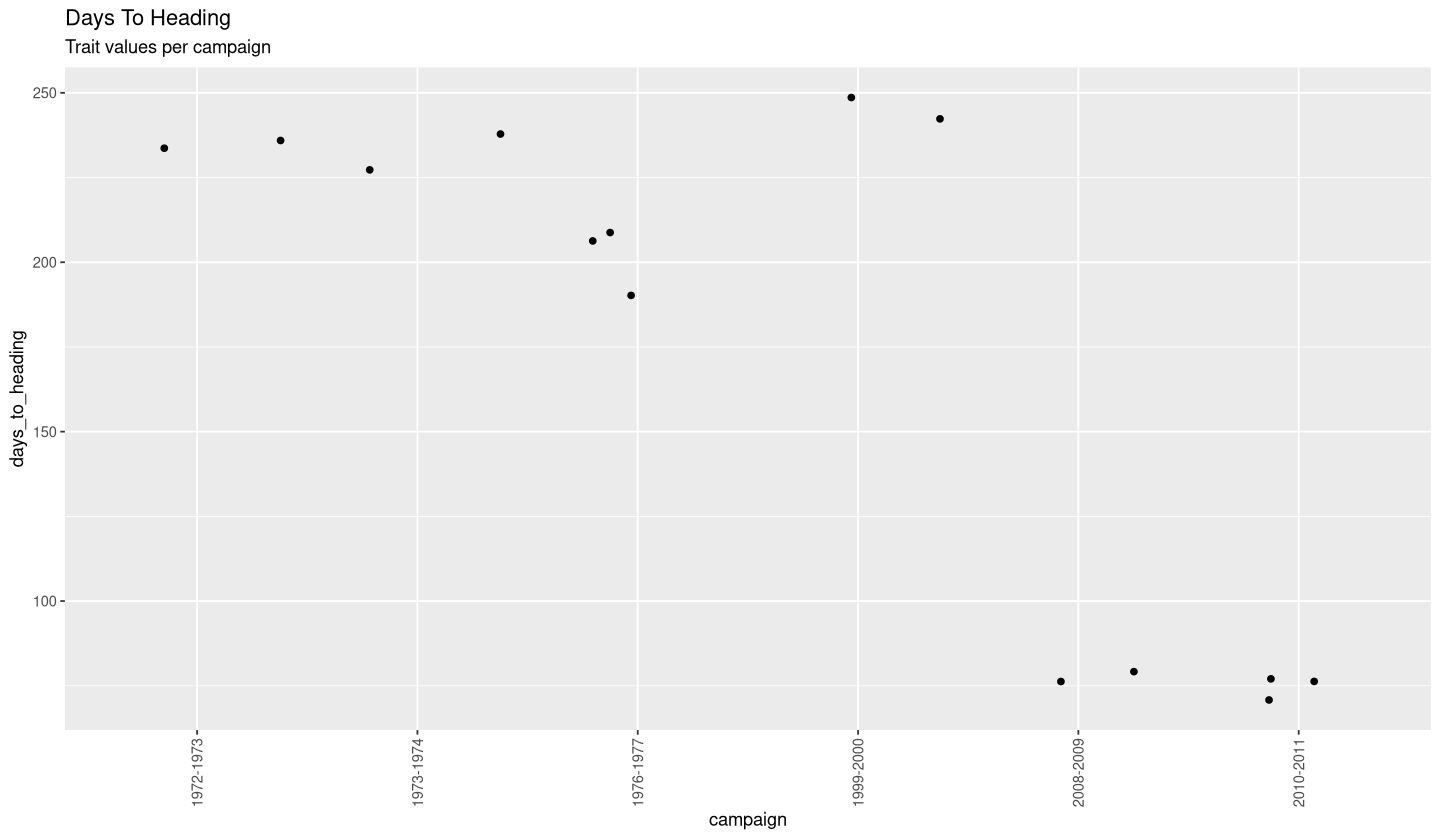

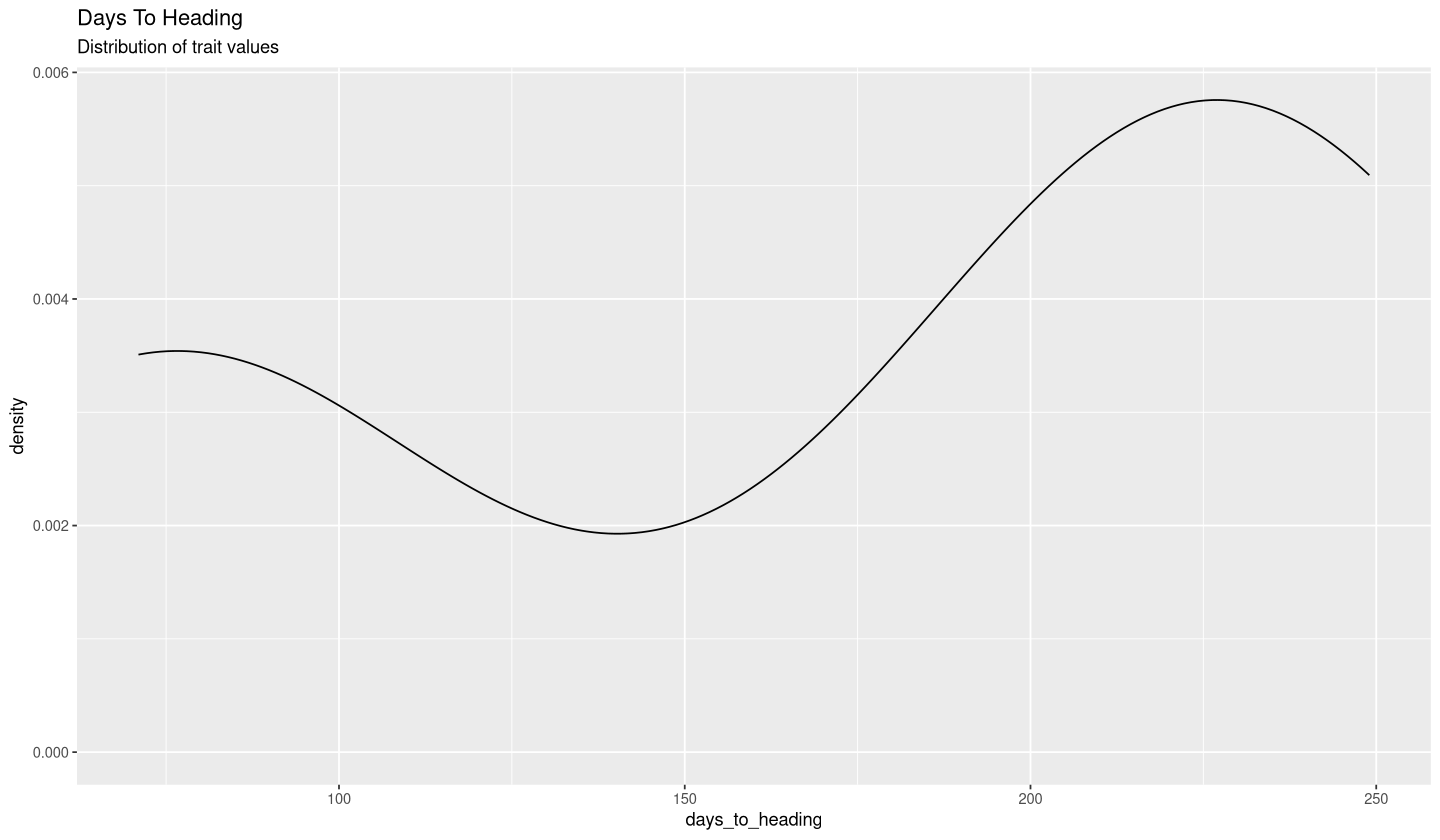

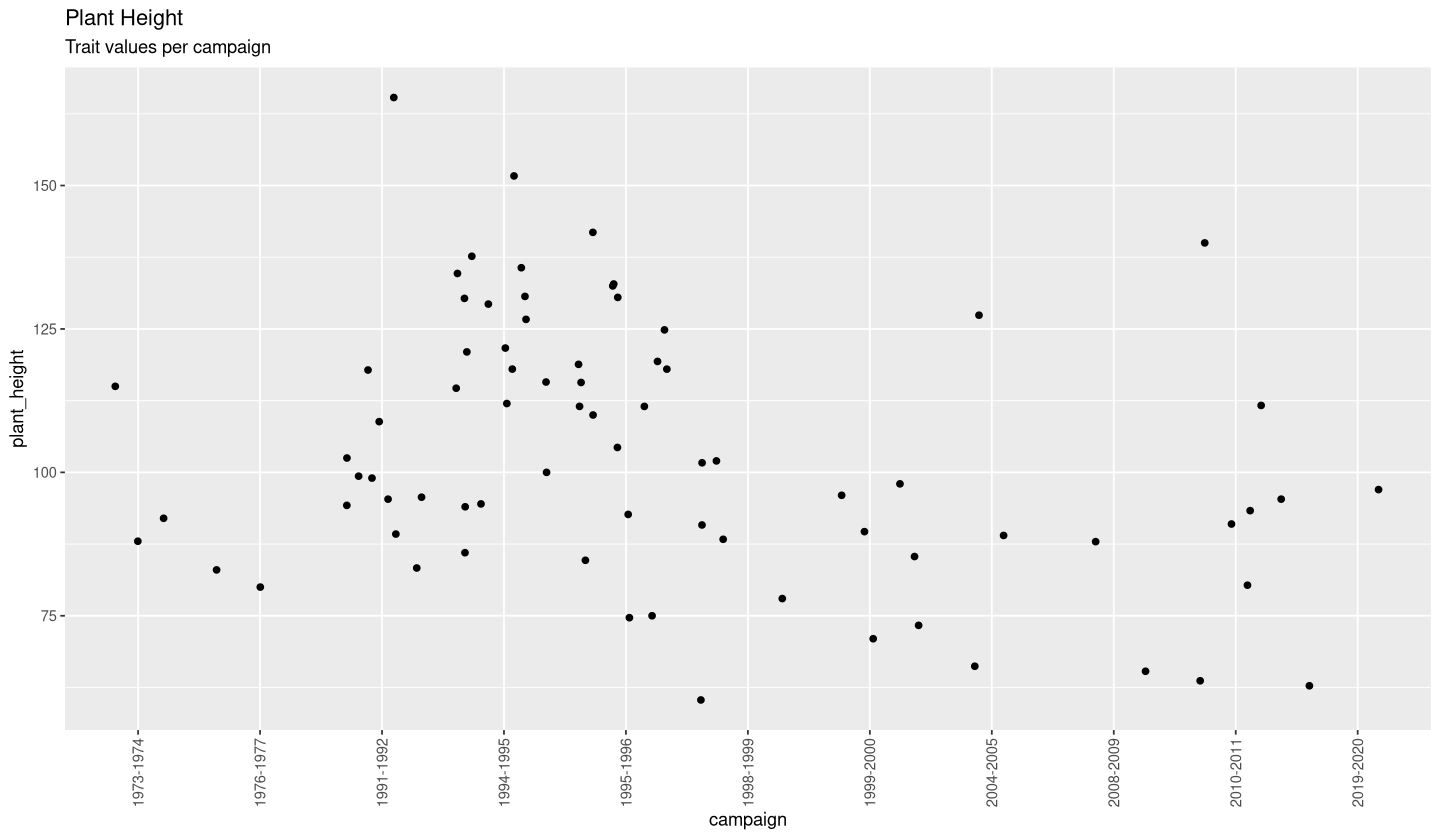

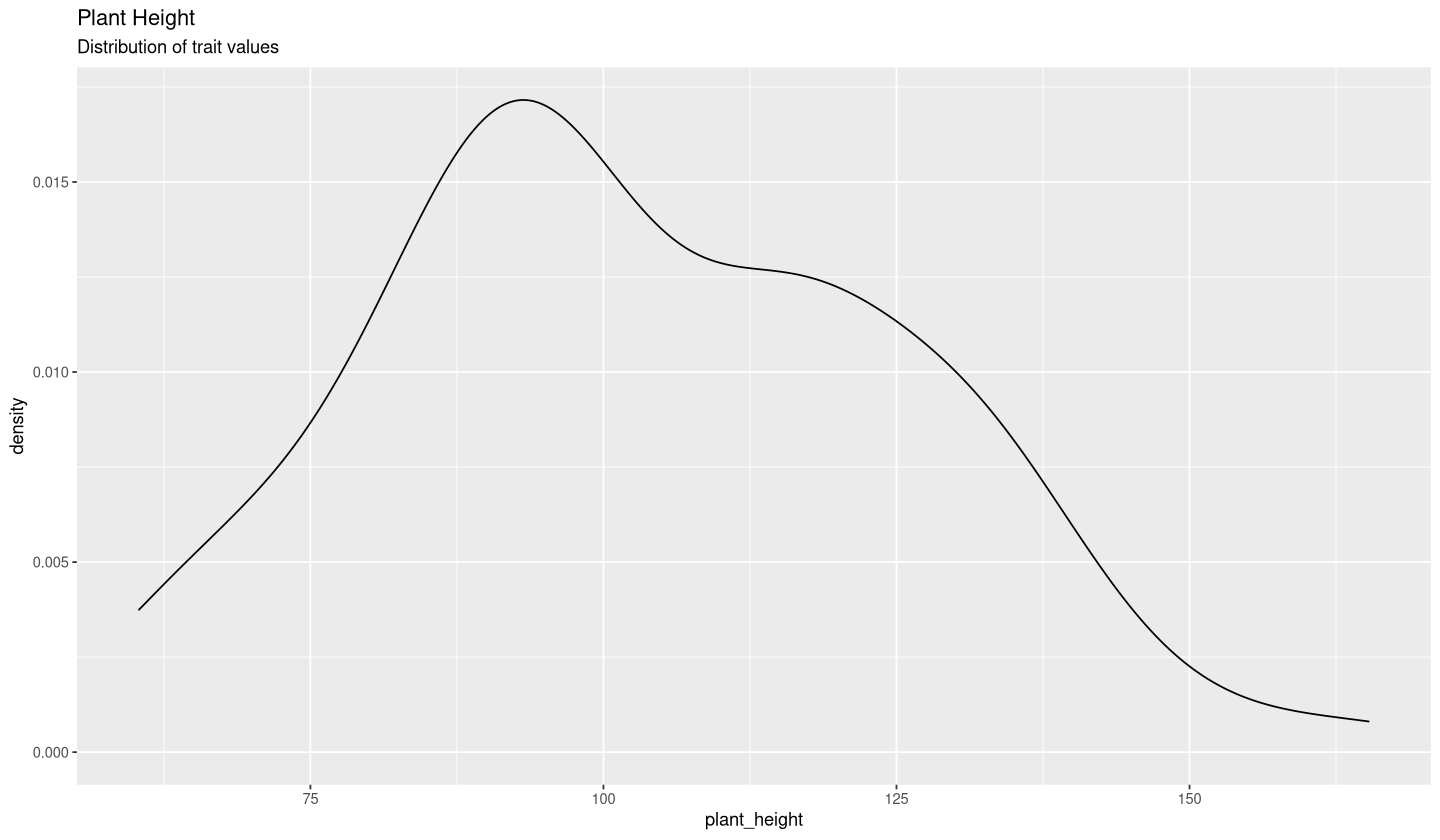

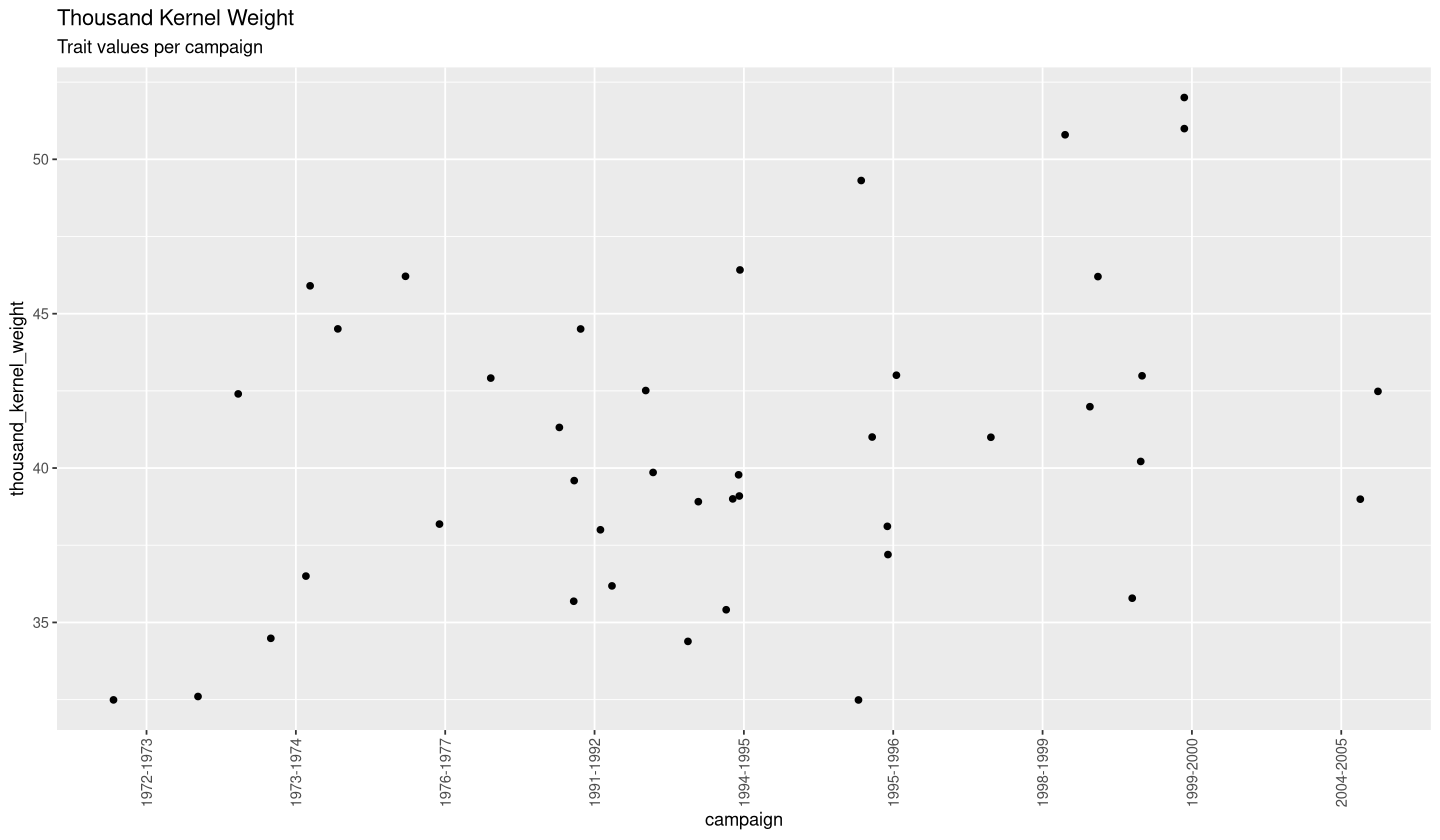

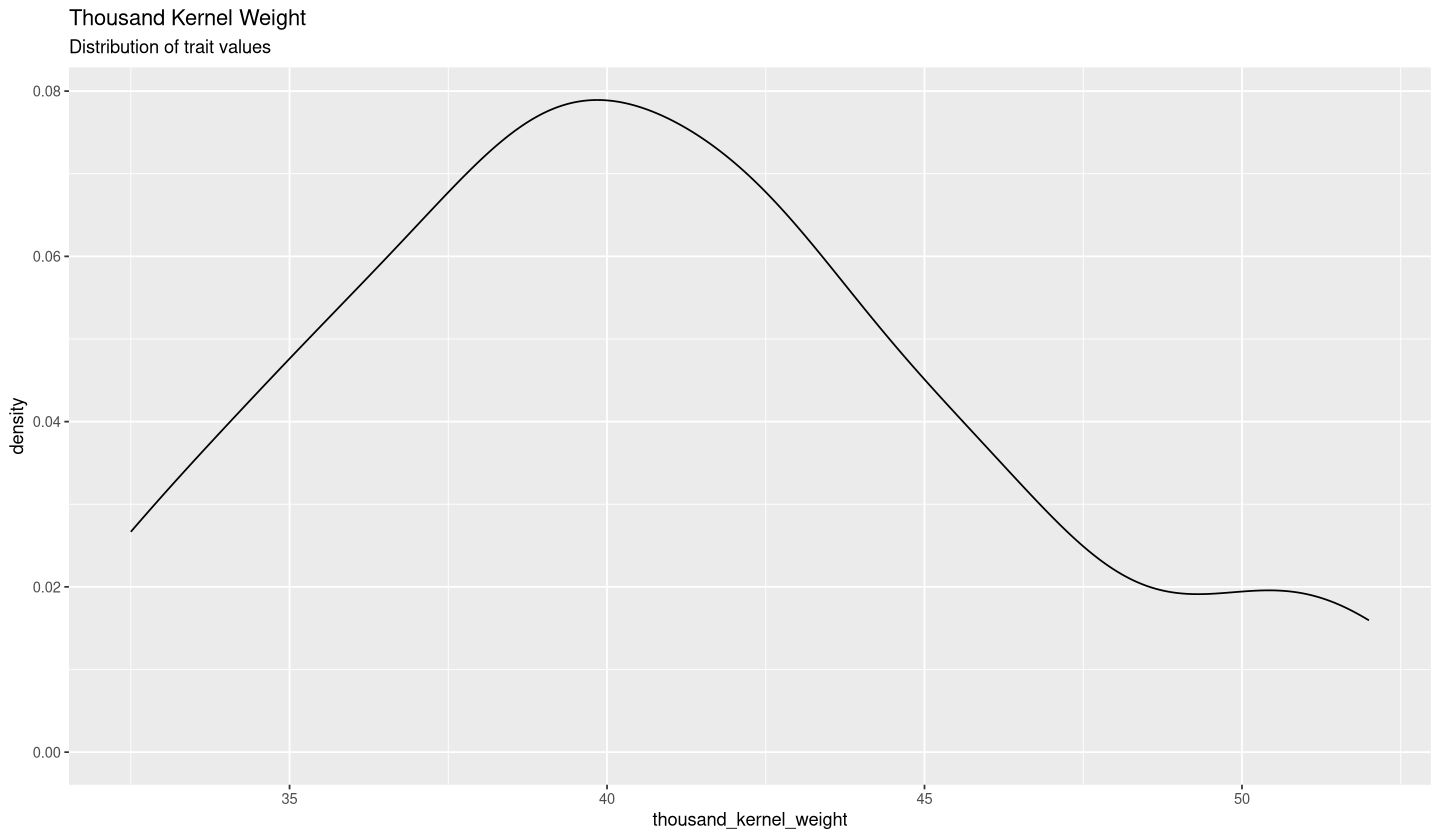

In [10]:
data_sub_SW_HT |> visualise_trait(geom_density())
data_sub_SW_PH |> visualise_trait(geom_density())
data_sub_SW_TKW |> visualise_trait(geom_density())

## Extract and format the campaign effects

In [11]:
asreml_campaign_WW_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
                             data = data_sub_WW_HT)

Online License checked out Wed Nov 15 19:13:34 2023
Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:34 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2291.820           1.0   1017 19:13:34    0.0 (2 restrained)
 2     -2265.380           1.0   1017 19:13:34    0.0 (2 restrained)
 3     -2246.202           1.0   1017 19:13:34    0.0 (2 restrained)
 4     -2239.529           1.0   1017 19:13:34    0.0 (2 restrained)
 5     -2238.395           1.0   1017 19:13:34    0.0 (2 restrained)
 6     -2238.380           1.0   1017 19:13:34    0.0 (1 restrained)
 7     -2238.379           1.0   1017 19:13:34    0.0 (1 restrained)
 8     -2238.380           1.0   1017 19:13:34    0.0 (1 restrained)


Warning message in asreml(fixed = days_to_heading ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration.”


In [12]:
asreml_campaign_WW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_WW_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:34 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -5795.512           1.0   1853 19:13:34    0.0 (1 restrained)
 2     -5695.472           1.0   1853 19:13:34    0.0 (1 restrained)
 3     -5595.232           1.0   1853 19:13:34    0.0 (2 restrained)
 4     -5560.133           1.0   1853 19:13:34    0.0 (1 restrained)
 5     -5512.177           1.0   1853 19:13:34    0.0
 6     -5490.816           1.0   1853 19:13:34    0.0
 7     -5485.743           1.0   1853 19:13:34    0.0
 8     -5481.687           1.0   1853 19:13:34    0.0
 9     -5479.269           1.0   1853 19:13:34    0.0
10     -5478.546           1.0   1853 19:13:34    0.0
11     -5478.333           1.0   1853 19:13:34    0.0
12     -5478.270           1.0   1853 19:13:34    0.0
13     -5478.251           1.0   1853 19:13:34    0.0


Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(fixed = plant_height ~ campaign, random = ~accenumb, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [13]:
asreml_campaign_WW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_WW_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:34 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3604.116           1.0   1650 19:13:34    0.0
 2     -3495.703           1.0   1650 19:13:34    0.0 (2 restrained)
 3     -3317.524           1.0   1650 19:13:34    0.0 (6 restrained)
 4     -3236.298           1.0   1650 19:13:34    0.0 (3 restrained)
 5     -3205.597           1.0   1650 19:13:34    0.0 (3 restrained)
 6     -3199.062           1.0   1650 19:13:34    0.0 (2 restrained)
 7     -3198.009           1.0   1650 19:13:34    0.0 (1 restrained)
 8     -3197.962           1.0   1650 19:13:34    0.0
 9     -3197.955           1.0   1650 19:13:34    0.0
10     -3197.954           1.0   1650 19:13:34    0.0
11     -3197.954           1.0   1650 19:13:34    0.0


In [14]:
# asreml_campaign_SW_HT <- asreml(fixed = days_to_heading ~campaign, random = ~accenumb, 
#                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign),
#                              data = data_sub_SW_HT)
# # Error: The estimation was aborted; too many exceptions.

In [15]:
asreml_campaign_SW_PH <- asreml(fixed = plant_height ~campaign, random = ~accenumb,
                             na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                             data = data_sub_SW_PH)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:34 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -236.602           1.0     66 19:13:34    0.0
 2      -232.079           1.0     66 19:13:34    0.0 (3 restrained)
 3      -225.010           1.0     66 19:13:34    0.0 (3 restrained)
 4      -217.867           1.0     66 19:13:34    0.0 (3 restrained)
 5      -214.664           1.0     66 19:13:34    0.0 (3 restrained)
 6      -213.834           1.0     66 19:13:34    0.0 (1 restrained)
 7      -213.638           1.0     66 19:13:34    0.0 (1 restrained)
 8      -213.629           1.0     66 19:13:34    0.0 (1 restrained)
 9      -213.629           1.0     66 19:13:34    0.0


In [16]:
asreml_campaign_SW_TKW <- asreml(fixed = thousand_kernel_weight ~campaign, random = ~accenumb,
                              na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                              data = data_sub_SW_TKW)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:34 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -71.5922           1.0     33 19:13:34    0.0 (1 restrained)
 2      -70.1582           1.0     33 19:13:34    0.0 (2 restrained)
 3      -68.2081           1.0     33 19:13:34    0.0 (5 restrained)
 4      -70.4369           1.0     33 19:13:34    0.0 (3 restrained)
 5      -66.6711           1.0     33 19:13:34    0.0 (3 restrained)
 6      -65.3970           1.0     33 19:13:34    0.0 (2 restrained)
 7      -63.6621           1.0     33 19:13:34    0.0 (1 restrained)
 8      -63.1892           1.0     33 19:13:34    0.0
 9      -63.1120           1.0     33 19:13:34    0.0
10      -63.1061           1.0     33 19:13:34    0.0


Warning message in asreml(fixed = thousand_kernel_weight ~ campaign, random = ~accenumb, :
“Some components changed by more than 1% on the last iteration.”


In [17]:
get_campaign_effect <- function(asreml_campaign){
                        intercept_index <- nrow(asreml_campaign$coeff$fixed)
                        intercept <- asreml_campaign$coeff$fixed[intercept_index]
                        campaign_effect <- asreml_campaign$coeff$fixed[-intercept_index,] + intercept
                        return(campaign_effect |> as.data.frame() |> rownames_to_column() |> 
                                mutate(campaign = str_sub(rowname,10)) |> 
                                select(campaign, campaign_effect))}

In [18]:
campaign_effect_WW_HT <- get_campaign_effect(asreml_campaign_WW_HT)
campaign_effect_WW_PH <- get_campaign_effect(asreml_campaign_WW_PH)
campaign_effect_WW_TKW <- get_campaign_effect(asreml_campaign_WW_TKW)

In [19]:
#campaign_effect_SW_HT <- get_campaign_effect(asreml_campaign_SW_HT)
campaign_effect_SW_PH <- get_campaign_effect(asreml_campaign_SW_PH)
campaign_effect_SW_TKW <- get_campaign_effect(asreml_campaign_SW_TKW)

## Extract heterogeneous error variances

In [20]:
get_error_var <- function(asreml_campaign){
                    summary(asreml_campaign)$varcomp |> slice(2:n()) |> select(std.error) |> 
                    as_tibble() |> rename("error_variance"="std.error")}

In [21]:
error_var_WW_HT <- get_error_var(asreml_campaign_WW_HT)
error_var_WW_PH <- get_error_var(asreml_campaign_WW_PH)
error_var_WW_TKW <- get_error_var(asreml_campaign_WW_TKW)

In [22]:
#error_var_SW_HT <- get_error_var(asreml_campaign_SW_HT)
error_var_SW_PH <- get_error_var(asreml_campaign_SW_PH)
error_var_SW_TKW <- get_error_var(asreml_campaign_SW_TKW)

## Calculate and standardize the coefficient of variation (CV)

In [23]:
make_CV_df <- function(campaign_effect, error_var){
                tibble(campaign_effect, error_var) |> 
                mutate(coefficient_of_variation=sqrt(error_variance)/campaign_effect) |> 
                mutate(standardized_CV=scale(coefficient_of_variation)[,1])}

In [24]:
CV_df_WW_HT <- make_CV_df(campaign_effect_WW_HT, error_var_WW_HT)
CV_df_WW_PH <- make_CV_df(campaign_effect_WW_PH, error_var_WW_PH)
CV_df_WW_TKW <- make_CV_df(campaign_effect_WW_TKW, error_var_WW_TKW)

In [25]:
#CV_df_SW_HT <- make_CV_df(campaign_effect_SW_HT, error_var_SW_HT)
CV_df_SW_PH <- make_CV_df(campaign_effect_SW_PH, error_var_SW_PH)
CV_df_SW_TKW <- make_CV_df(campaign_effect_SW_TKW, error_var_SW_TKW)

## Remove outlier campaigns

In [26]:
correct_I <- function(data_sub, CV_df){
                        outlier_campaigns <- CV_df |> filter(standardized_CV > 3.5) |> select(campaign)
                        cat(nrow(outlier_campaigns), "outlier campaign(s) detected for trait", colnames(data_sub)[3], "\n")
                        return(data_sub |> filter(! campaign %in% outlier_campaigns) |>
                               group_by(campaign) |> filter(n()>1) |> ungroup())}

In [27]:
data_corrected_WW_HT_I <- data_sub_WW_HT |> correct_I(CV_df_WW_HT)
data_corrected_WW_PH_I <- data_sub_WW_PH |> correct_I(CV_df_WW_PH)
data_corrected_WW_TKW_I <- data_sub_WW_TKW |> correct_I(CV_df_WW_TKW)

0 outlier campaign(s) detected for trait days_to_heading 
1 outlier campaign(s) detected for trait plant_height 
0 outlier campaign(s) detected for trait thousand_kernel_weight 


In [28]:
#data_corrected_SW_HT_I <- data_sub_SW_HT |> correct_I(CV_df_SW_HT)
data_corrected_SW_PH_I <- data_sub_SW_PH |> correct_I(CV_df_SW_PH)
data_corrected_SW_TKW_I <- data_sub_SW_TKW |> correct_I(CV_df_SW_TKW)

0 outlier campaign(s) detected for trait plant_height 
0 outlier campaign(s) detected for trait thousand_kernel_weight 


## Residuals

In [29]:
asreml_res_WW_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_HT_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:35 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1789.991           1.0    711 19:13:35    0.0 (3 restrained)
 2     -1741.172           1.0    711 19:13:35    0.0 (2 restrained)
 3     -1699.563           1.0    711 19:13:35    0.0 (2 restrained)
 4     -1678.434           1.0    711 19:13:35    0.0 (3 restrained)
 5     -1670.793           1.0    711 19:13:35    0.0 (2 restrained)
 6     -1667.470           1.0    711 19:13:35    0.0 (2 restrained)
 7     -1666.952           1.0    711 19:13:35    0.0 (2 restrained)
 8     -1666.922           1.0    711 19:13:35    0.0 (1 restrained)
 9     -1666.921           1.0    711 19:13:35    0.0 (1 restrained)


Warning message in asreml(fixed = days_to_heading ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


In [30]:
asreml_res_WW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_WW_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:35 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -3264.820           1.0   1105 19:13:35    0.2 (7 restrained)
 2     -3176.076           1.0   1105 19:13:36    0.1
 3     -3117.747           1.0   1105 19:13:36    0.1
 4     -3088.172           1.0   1105 19:13:36    0.1
 5     -3078.271           1.0   1105 19:13:36    0.1 (1 restrained)
 6     -3076.997           1.0   1105 19:13:36    0.2 (1 restrained)
 7     -3076.876           1.0   1105 19:13:36    0.1 (1 restrained)
 8     -3076.857           1.0   1105 19:13:37    0.1 (1 restrained)
 9     -3076.828           1.0   1105 19:13:37    0.1
10     -3076.828           1.0   1105 19:13:37    0.1


In [31]:
asreml_res_WW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_WW_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:37 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2162.125           1.0   1032 19:13:37    0.1 (10 restrained)
 2     -2017.377           1.0   1032 19:13:37    0.1 (4 restrained)
 3     -1964.308           1.0   1032 19:13:37    0.1 (3 restrained)
 4     -1939.144           1.0   1032 19:13:37    0.1 (3 restrained)
 5     -1933.087           1.0   1032 19:13:37    0.1 (2 restrained)
 6     -1932.103           1.0   1032 19:13:38    0.1 (1 restrained)
 7     -1932.448           1.0   1032 19:13:38    0.1
 8     -1932.433           1.0   1032 19:13:38    0.1
 9     -1932.429           1.0   1032 19:13:38    0.1
10     -1932.427           1.0   1032 19:13:38    0.1
11     -1932.427           1.0   1032 19:13:38    0.1


In [32]:
# asreml_res_SW_HT <- asreml(fixed = days_to_heading ~ accenumb, random = ~ campaign,
#                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                  data = data_corrected_SW_HT_I)

In [33]:
asreml_res_SW_PH <- asreml(fixed = plant_height ~ accenumb, random = ~ campaign, 
                 na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                 data = data_corrected_SW_PH_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:38 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -128.770           1.0     37 19:13:38    0.0 (3 restrained)
 2      -110.147           1.0     37 19:13:38    0.0 (3 restrained)
 3      -106.867           1.0     37 19:13:38    0.0 (3 restrained)
 4      -106.950           1.0     37 19:13:38    0.0 (4 restrained)
 5      -116.342           1.0     37 19:13:38    0.0 (2 restrained)
 6      -112.667           1.0     37 19:13:38    0.0 (2 restrained)
 7      -109.599           1.0     37 19:13:38    0.0 (3 restrained)
 8      -106.605           1.0     37 19:13:38    0.0 (2 restrained)
 9      -102.964           1.0     37 19:13:38    0.0
10      -102.674           1.0     37 19:13:38    0.0
11      -102.611           1.0     37 19:13:38    0.0
12      -102.629           1.0     37 19:13:38    0.0


Warning message in asreml(fixed = plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [34]:
asreml_res_SW_TKW <- asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~ campaign, 
                  na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                  data = data_corrected_SW_TKW_I)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:38 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -53.2731           1.0     20 19:13:38    0.0 (4 restrained)
 2      -53.9764           1.0     20 19:13:38    0.0 (4 restrained)
 3      -44.3763           1.0     20 19:13:38    0.0 (4 restrained)
 4      -46.3625           1.0     20 19:13:38    0.0 (3 restrained)
 5      -43.3553           1.0     20 19:13:38    0.0 (2 restrained)
 6      -41.0821           1.0     20 19:13:38    0.0 (3 restrained)
 7      -50.1386           1.0     20 19:13:38    0.0 (1 restrained)
 8      -45.6190           1.0     20 19:13:38    0.0 (1 restrained)
 9      -42.1230           1.0     20 19:13:38    0.0 (1 restrained)
10      -39.8944           1.0     20 19:13:38    0.0
11      -38.8461           1.0     20 19:13:38    0.0
12      -38.1994           1.0     20 19:13:38    0.0
13      -37.8373           1.0     20 19:13:38    0.0


Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Log-likelihood not converged”
Warning message in asreml(fixed = thousand_kernel_weight ~ accenumb, random = ~campaign, :
“Some components changed by more than 1% on the last iteration.”


In [35]:
make_BH_multtest <- function(asreml_res){
            trait_title <- colnames(asreml_res$mf)[3] |> str_replace_all("_", " ") |> str_to_title()
            residual <- asreml_res$residuals
            MAD <- 1.4826*median(abs(residual-median(residual))) #approx constant https://en.wikipedia.org/wiki/Median_absolute_deviation#Relation_to_standard_deviation
            rawp_BHStud <- 2 * (1 - pnorm(abs(residual/MAD)))
            test_BHStud <- mt.rawp2adjp(rawp_BHStud, proc=c("Holm"))
            result_df <- tibble(adjp=test_BHStud[[1]][,1], bholm=test_BHStud[[1]][,2], index=test_BHStud[[2]]) |>
                    mutate(is_outlier = bholm < 0.05) |> arrange(index) |> mutate(std_residual = scale(residual)[,1])
            cat(sum(result_df$is_outlier), "outlier value(s) detected for trait", trait_title, "\n")
            plot(ggplot(result_df, aes(index,std_residual, color=is_outlier)) + geom_jitter()
                 + scale_colour_manual(values = c("TRUE" = "#A51D2D", "FALSE" = "#26A269"))
                 + labs(title = trait_title, subtitle = "Outlier detection with Bonferroni–Holm method"))
            return(result_df |> as.data.frame())}

132 outlier value(s) detected for trait Days To Heading 
74 outlier value(s) detected for trait Plant Height 


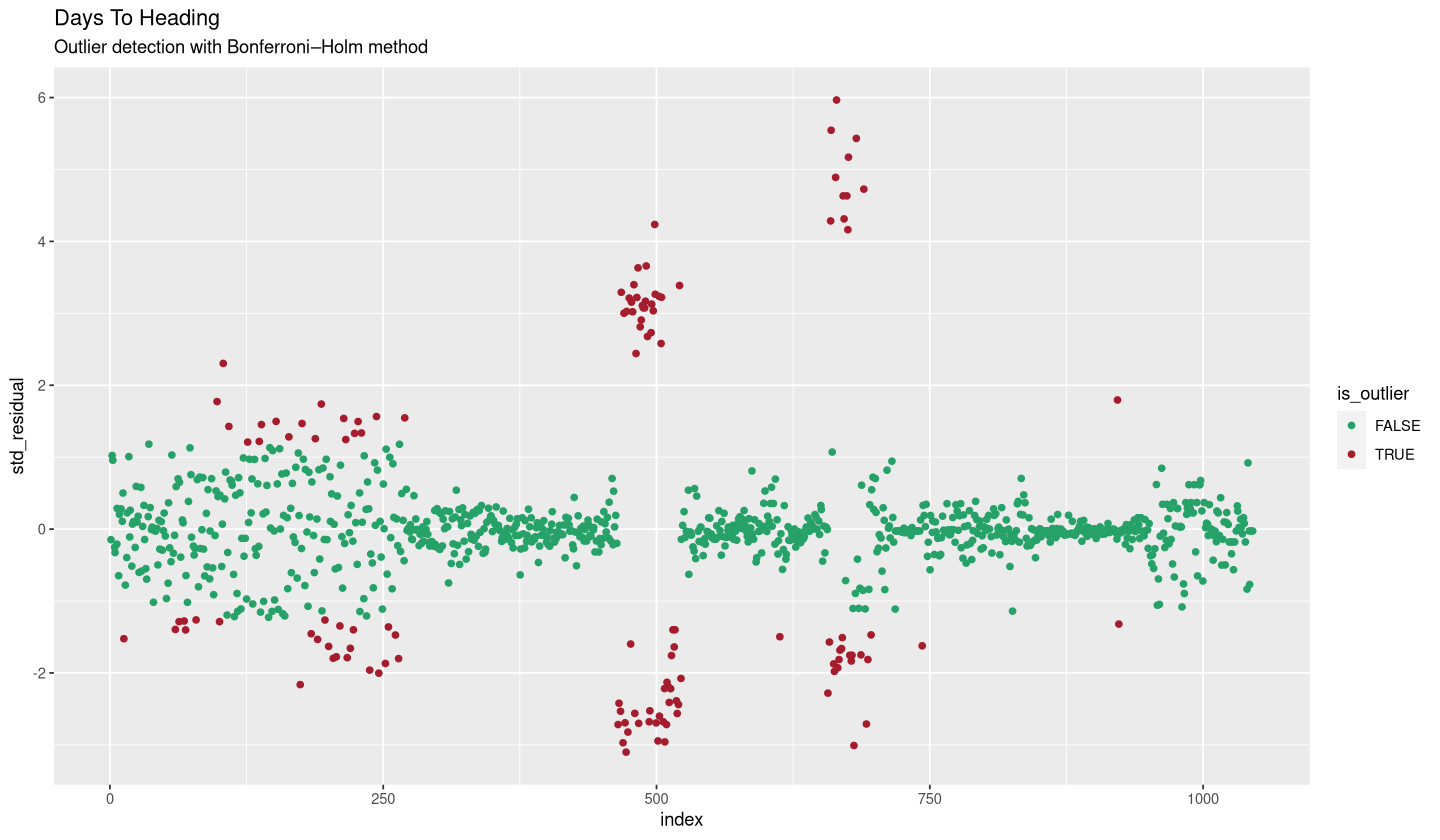

249 outlier value(s) detected for trait Thousand Kernel Weight 


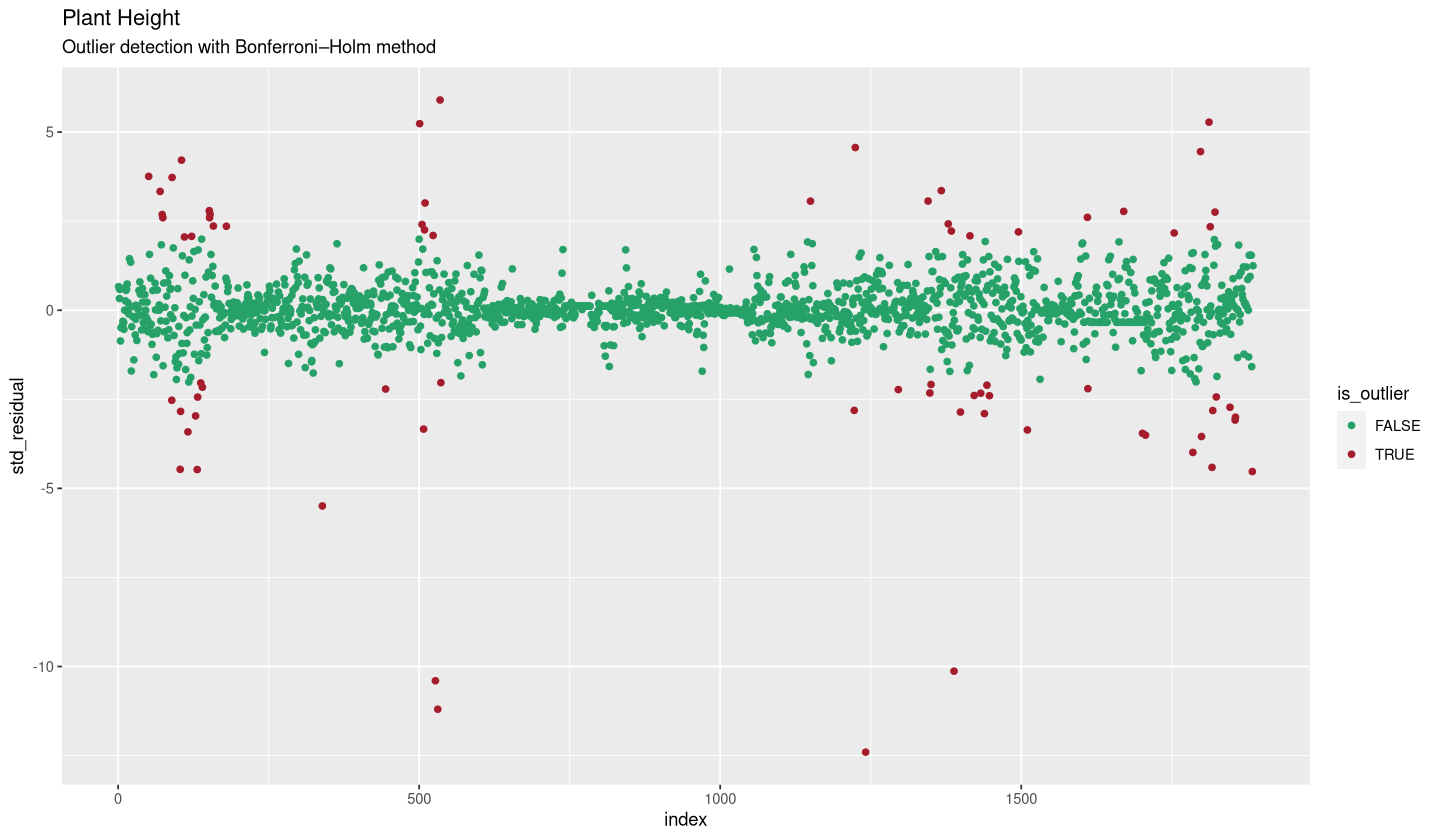

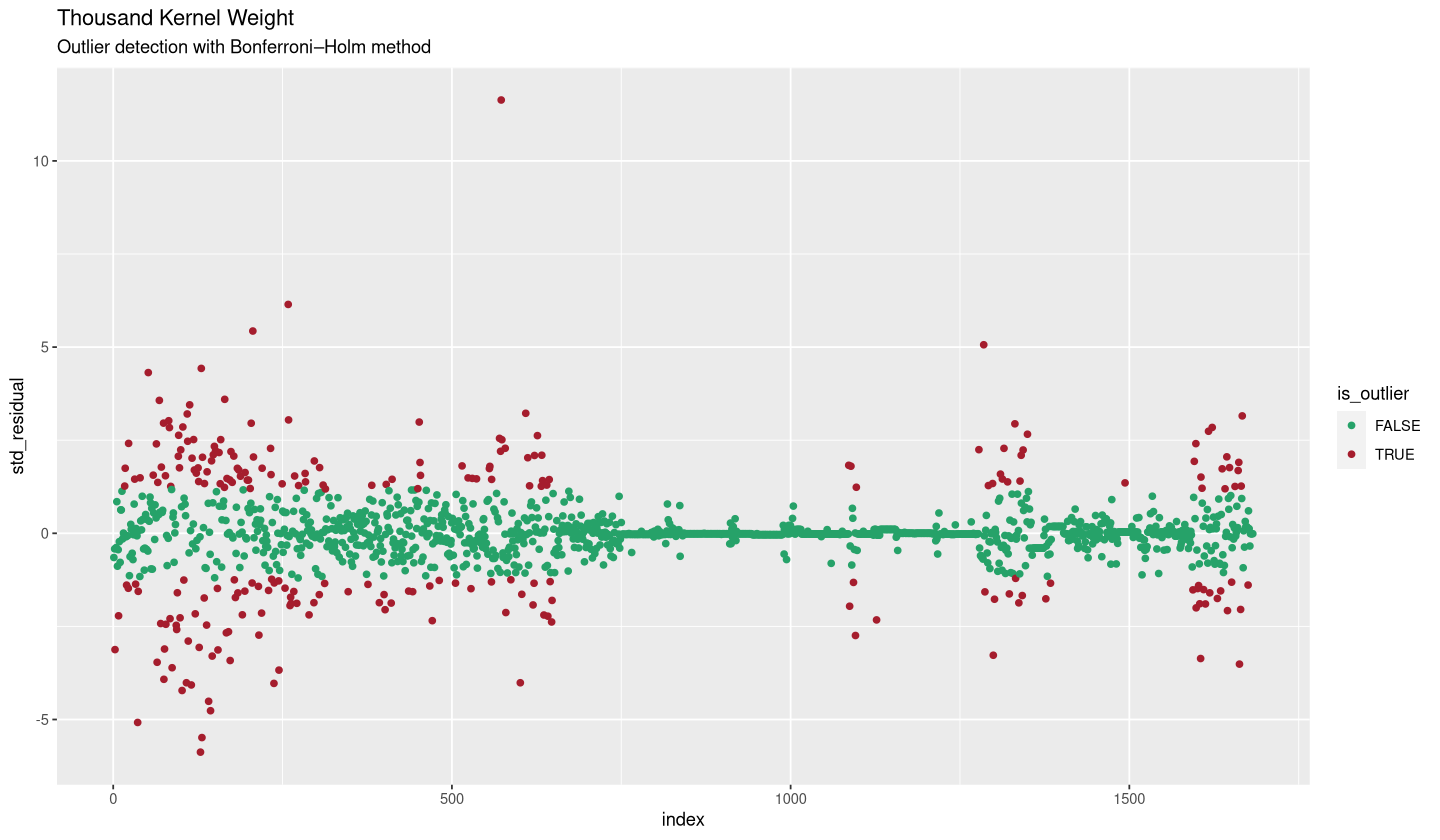

In [36]:
result_BH_WW_HT <- make_BH_multtest(asreml_res_WW_HT)
result_BH_WW_PH <- make_BH_multtest(asreml_res_WW_PH)
result_BH_WW_TKW <- make_BH_multtest(asreml_res_WW_TKW)

21 outlier value(s) detected for trait Plant Height 
18 outlier value(s) detected for trait Thousand Kernel Weight 


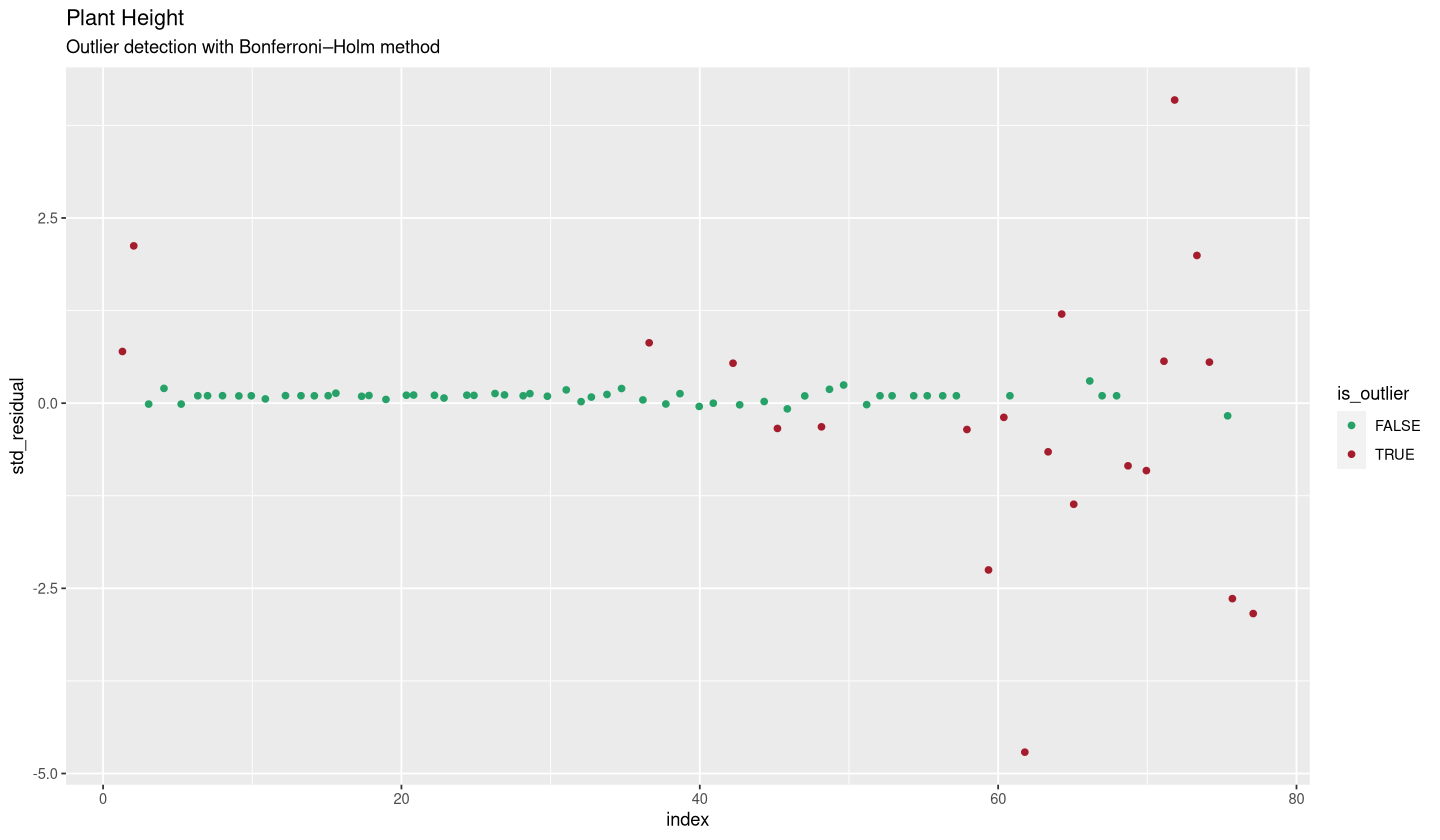

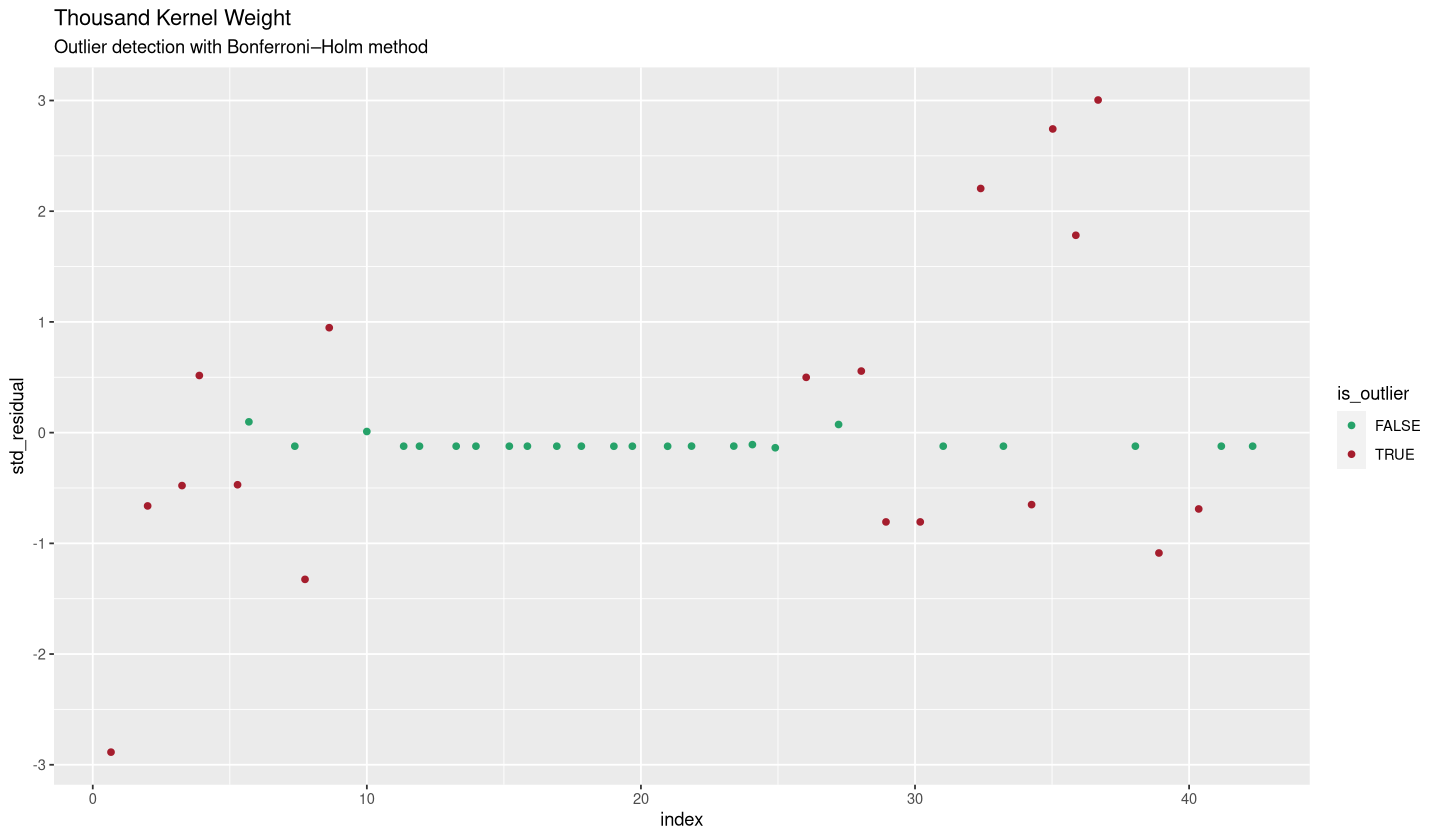

In [37]:
#result_BH_SW_HT <- make_BH_multtest(asreml_res_SW_HT)
result_BH_SW_PH <- make_BH_multtest(asreml_res_SW_PH)
result_BH_SW_TKW <- make_BH_multtest(asreml_res_SW_TKW)

In [38]:
correct_II <- function(data_corrected_I, result_BH){
                        data_corrected_I[result_BH[which(!result_BH$is_outlier),"index"],] |> 
                        group_by(accenumb) |> filter(n() > 1) |> group_by(campaign) |> filter(n() > 1) |> 
                        arrange(campaign, accenumb) |> as.data.frame() |> droplevels()}

In [39]:
data_corrected_WW_HT_II <- data_corrected_WW_HT_I |> correct_II(result_BH_WW_HT)
data_corrected_WW_PH_II <- data_corrected_WW_PH_I |> correct_II(result_BH_WW_PH)
data_corrected_WW_TKW_II <- data_corrected_WW_TKW_I |> correct_II(result_BH_WW_TKW)

In [40]:
#data_corrected_SW_HT_II <- data_corrected_SW_HT_I |> correct_II(result_BH_SW_HT)
data_corrected_SW_PH_II <- data_corrected_SW_PH_I |> correct_II(result_BH_SW_PH)
data_corrected_SW_TKW_II <- data_corrected_SW_TKW_I |> correct_II(result_BH_SW_TKW)

## Calculate heritability

In [41]:
asreml_res_h_WW_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:40 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1876.207           1.0    875 19:13:40    0.0 (1 restrained)
 2     -1823.831           1.0    875 19:13:40    0.0 (1 restrained)
 3     -1773.196           1.0    875 19:13:40    0.0 (1 restrained)
 4     -1742.765           1.0    875 19:13:40    0.0 (1 restrained)
 5     -1726.816           1.0    875 19:13:40    0.0
 6     -1721.455           1.0    875 19:13:40    0.0
 7     -1720.195           1.0    875 19:13:40    0.0
 8     -1720.069           1.0    875 19:13:40    0.0
 9     -1720.065           1.0    875 19:13:40    0.0


Warning message in asreml(days_to_heading ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [42]:
asreml_res_h_WW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:40 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -5379.594           1.0   1774 19:13:40    0.0 (2 restrained)
 2     -5244.947           1.0   1774 19:13:40    0.0 (3 restrained)
 3     -5112.854           1.0   1774 19:13:40    0.0 (1 restrained)
 4     -5019.681           1.0   1774 19:13:40    0.0 (2 restrained)
 5     -4954.426           1.0   1774 19:13:40    0.0 (1 restrained)
 6     -4914.836           1.0   1774 19:13:40    0.0
 7     -4906.567           1.0   1774 19:13:40    0.0
 8     -4904.917           1.0   1774 19:13:40    0.0
 9     -4904.507           1.0   1774 19:13:40    0.0
10     -4904.386           1.0   1774 19:13:40    0.0
11     -4904.351           1.0   1774 19:13:40    0.0
12     -4904.341           1.0   1774 19:13:40    0.0
13     -4904.338           1.0   1774 19:13:40    0.0


Warning message in asreml(plant_height ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(plant_height ~ 1, random = ~accenumb + campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [43]:
asreml_res_h_WW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
                    na.action = na.method(x="omit", y="omit"),
                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_WW_TKW_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2719.228           1.0   1343 19:13:41    0.0 (1 restrained)
 2     -2519.998           1.0   1343 19:13:41    0.0 (11 restrained)
 3     -2180.067           1.0   1343 19:13:41    0.0 (8 restrained)
 4     -2015.737           1.0   1343 19:13:41    0.0 (6 restrained)
 5     -1975.414           1.0   1343 19:13:41    0.0 (7 restrained)
 6     -1942.044           1.0   1343 19:13:41    0.0 (9 restrained)
Log-likelihood decreased to  -2113.95 ; trying with reduced updates (0.36445)
 7     -1928.455           1.0   1343 19:13:41    0.0 (1 restrained)
 8     -1925.325           1.0   1343 19:13:41    0.0 (1 restrained)
 9     -1921.980           1.0   1343 19:13:41    0.0 (1 restrained)
10     -1920.395           1.0   1343 19:13:41    0.0 (1 restrained)
11     -1920.093           1.0   1343 19:13:41    0.0 (1 restrained)
12     -1920.087

Warning message in asreml(thousand_kernel_weight ~ 1, random = ~accenumb + campaign, :
“Log-likelihood not converged”


In [44]:
# asreml_res_h_SW_HT <- asreml(days_to_heading ~1, random = ~accenumb + campaign, 
#                    na.action = na.method(x="omit", y="omit"), 
#                    residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_HT_II)

In [45]:
asreml_res_h_SW_PH <- asreml(plant_height ~1, random = ~accenumb + campaign, 
                   na.action = na.method(x="omit", y="omit"), 
                   residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -109.802           1.0     31 19:13:41    0.0 (1 restrained)
 2      -105.280           1.0     31 19:13:41    0.0 (2 restrained)
 3       -97.688           1.0     31 19:13:41    0.0 (3 restrained)
 4       -79.931           1.0     31 19:13:41    0.0 (3 restrained)
 5       -80.174           1.0     31 19:13:41    0.0 (1 restrained)
 6       -74.921           1.0     31 19:13:41    0.0
 7       -73.513           1.0     31 19:13:41    0.0
 8       -73.291           1.0     31 19:13:41    0.0
 9       -73.281           1.0     31 19:13:41    0.0


In [46]:
# asreml_res_h_SW_TKW <- asreml(thousand_kernel_weight ~1, random = ~accenumb + campaign, 
#                     na.action = na.method(x="omit", y="omit"),
#                     residual = ~dsum( ~id(units) | campaign), data = data_corrected_SW_TKW_II)
# # Error: Singularities in the average information matrix.

In [47]:
get_quality <- function(data_sub, asreml_res_h){
                trait <- colnames(data_sub)[3]
                varcomp <- summary(asreml_res_h)$varcomp
                var_G <- varcomp[2,"component"]
                var_E <- mean(varcomp[3:nrow(varcomp),"component"])
                no_campaigns <- mean(table(data_sub$accenumb[!is.na(data_sub[,trait])]))
                heritability <- var_G/(var_G+(var_E/no_campaigns))
                cat(colnames(data_sub)[3], "heritability:", round(heritability*100,1), "%\n")
                return(tibble(trait, heritability, var_G, var_E, no_campaigns))}

In [48]:
quality_WW_HT <- get_quality(data_sub_WW_HT, asreml_res_h_WW_HT)
quality_WW_PH <- get_quality(data_sub_WW_PH, asreml_res_h_WW_PH)
quality_WW_TKW <- get_quality(data_sub_WW_TKW, asreml_res_h_WW_TKW)
quality_WW_all <- bind_rows(quality_WW_HT, quality_WW_PH, quality_WW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
write_csv(quality_WW_all,"NPPC_winter_wheat_data_quality.csv")

days_to_heading heritability: 74.2 %
plant_height heritability: 93.6 %
thousand_kernel_weight heritability: 94.7 %


In [49]:
#quality_SW_HT <- get_quality(data_sub_SW_HT, asreml_res_h_SW_HT)
quality_SW_PH <- get_quality(data_sub_SW_PH, asreml_res_h_SW_PH)
#quality_SW_TKW <- get_quality(data_sub_SW_TKW, asreml_res_h_SW_TKW)
#quality_SW_all <- bind_rows(quality_SW_HT, quality_SW_PH, quality_SW_TKW) |> mutate(across(-1, \(x) round(x, 3)))
#write_csv(quality_SW_all,"NPPC_spring_wheat_data_quality.csv")

plant_height heritability: 99.8 %


## Run linear mixed model with outlier corrected data

In [50]:
asreml_data_WW_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_HT_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -1284.329           1.0    577 19:13:41    0.0 (3 restrained)
 2     -1233.022           1.0    577 19:13:41    0.0 (2 restrained)
 3     -1191.365           1.0    577 19:13:41    0.0 (3 restrained)
 4     -1165.529           1.0    577 19:13:41    0.0 (4 restrained)
 5     -1153.334           1.0    577 19:13:41    0.0 (4 restrained)
 6     -1147.411           1.0    577 19:13:41    0.0 (4 restrained)
 7     -1145.380           1.0    577 19:13:41    0.0 (3 restrained)
 8     -1144.782           1.0    577 19:13:41    0.0 (3 restrained)
 9     -1144.667           1.0    577 19:13:41    0.0 (2 restrained)
10     -1144.668           1.0    577 19:13:41    0.0 (1 restrained)
11     -1144.668           1.0    577 19:13:41    0.0


In [51]:
asreml_data_WW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_WW_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:41 2023
          LogLik        Sigma2     DF     wall    cpu
 1     -2822.886           1.0   1033 19:13:42    0.2 (11 restrained)
 2     -2684.062           1.0   1033 19:13:42    0.1
 3     -2604.651           1.0   1033 19:13:42    0.1
 4     -2559.580           1.0   1033 19:13:42    0.1
 5     -2543.204           1.0   1033 19:13:42    0.1
 6     -2541.030           1.0   1033 19:13:42    0.1 (1 restrained)
 7     -2540.629           1.0   1033 19:13:42    0.1 (1 restrained)
 8     -2540.590           1.0   1033 19:13:43    0.1 (1 restrained)
 9     -2540.570           1.0   1033 19:13:43    0.1
10     -2540.564           1.0   1033 19:13:43    0.1
11     -2540.554           1.0   1033 19:13:43    0.1
12     -2540.536           1.0   1033 19:13:43    0.1 (1 restrained)
13     -2540.522           1.0   1033 19:13:43    0.1 (1 restrained)


Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Log-likelihood not converged”
Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [52]:
# asreml_data_WW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
#                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                           data = data_corrected_WW_TKW_II)
# # Error: The estimation was aborted; too many exceptions.

In [53]:
# asreml_data_SW_HT <- asreml(days_to_heading ~accenumb, random = ~campaign, 
#                          na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                          data = data_corrected_SW_HT_II)

In [54]:
asreml_data_SW_PH <- asreml(plant_height ~accenumb, random = ~campaign, 
                         na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
                         data = data_corrected_SW_PH_II)

Multi-section model using the sigma parameterization.
ASReml 4.1.0 Wed Nov 15 19:13:43 2023
          LogLik        Sigma2     DF     wall    cpu
 1      -45.3057           1.0     16 19:13:43    0.0 (4 restrained)
 2      -29.3993           1.0     16 19:13:43    0.0 (3 restrained)
 3      -20.4991           1.0     16 19:13:43    0.0 (2 restrained)
 4      -21.0548           1.0     16 19:13:43    0.0 (1 restrained)
 5      -20.1073           1.0     16 19:13:43    0.0 (2 restrained)
 6      -20.8637           1.0     16 19:13:43    0.0 (1 restrained)
 7      -20.0174           1.0     16 19:13:43    0.0
 8      -19.9754           1.0     16 19:13:43    0.0
 9      -19.9669           1.0     16 19:13:43    0.0


Warning message in asreml(plant_height ~ accenumb, random = ~campaign, na.action = na.method(x = "omit", :
“Some components changed by more than 1% on the last iteration.”


In [55]:
# asreml_data_SW_TKW <- asreml(thousand_kernel_weight ~accenumb, random = ~campaign, 
#                           na.action = na.method(x="omit", y="omit"), residual = ~dsum(~id(units) | campaign), 
#                           data = data_corrected_SW_TKW_II)
# # Error: Singularities in the average information matrix.

## Extract BLUEs and create output file

In [56]:
get_BLUEs <- function(asreml_data){
                            trait <- colnames(asreml_data$mf)[3]
                            intercept_index <- nrow(asreml_data$coeff$fixed)
                            intercept <- asreml_data$coeff$fixed[intercept_index]
                            BLUE <- asreml_data$coeff$fixed[-intercept_index,] + intercept
                            return(BLUE |> as.data.frame() |>
                                    rownames_to_column() |>
                                    mutate(genotype=str_split_i(rowname,"_", -1)) |> #assuming there is no underscore in the accession numbers
                                    select(genotype, BLUE) |> rename_with(~paste(trait, .x, sep="_"), 2))}

In [57]:
BLUEs_WW_HT <- get_BLUEs(asreml_data_WW_HT)
BLUEs_WW_PH <- get_BLUEs(asreml_data_WW_PH)
#BLUEs_WW_TKW <- get_BLUEs(asreml_data_WW_TKW)

BLUE_WW_all <- genotypes_w |> 
                        left_join(BLUEs_WW_HT, by="genotype") |> 
                        left_join(BLUEs_WW_PH, by="genotype") |> 
                        #left_join(BLUEs_WW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_WW_all,"NPPC_winter_wheat_BLUE_values.csv")
summary(BLUE_WW_all)

   genotype         days_to_heading_BLUE plant_height_BLUE
 Length:4893        Min.   :212.4        Min.   : 57.02   
 Class :character   1st Qu.:221.9        1st Qu.: 83.67   
 Mode  :character   Median :224.4        Median : 92.25   
                    Mean   :224.7        Mean   : 94.35   
                    3rd Qu.:227.7        3rd Qu.:102.19   
                    Max.   :240.1        Max.   :150.99   
                    NA's   :4594         NA's   :4151     

In [58]:
#BLUEs_SW_HT <- get_BLUEs(asreml_data_SW_HT)
BLUEs_SW_PH <- get_BLUEs(asreml_data_SW_PH)
#BLUEs_SW_TKW <- get_BLUEs(asreml_data_SW_TKW)


BLUE_SW_all <- genotypes_s |> 
                        #left_join(BLUEs_SW_HT, by="genotype") |> 
                        left_join(BLUEs_SW_PH, by="genotype") |> 
                        #left_join(BLUEs_SW_TKW, by="genotype") |> 
                        arrange(genotype) |> mutate(across(-1, \(x) round(x, 2)))

write_csv(BLUE_SW_all,"NPPC_spring_wheat_BLUE_values.csv")
summary(BLUE_SW_all)

   genotype         plant_height_BLUE
 Length:891         Min.   : 79.04   
 Class :character   1st Qu.: 93.92   
 Mode  :character   Median :109.77   
                    Mean   :108.44   
                    3rd Qu.:121.86   
                    Max.   :145.72   
                    NA's   :875      

In [59]:
library(rmarkdown)
convert_ipynb("NPPC_historic_wheat_data_analysis.ipynb")

In [60]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: FlexiBLAS OPENBLAS-OPENMP;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rmarkdown_2.25      asreml_4.1.0.154    Matrix_1.6-3       
 [4] multtest_2.56.0     Biobase_2.60.0      BiocGenerics_0.46.0
 [7] lubridate_1.9.3     forcats_1.0.0       stringr_1.5.1      
[10] dplyr_1.1.3         purrr_1.0.2         readr_